In [40]:
from hasp.make_feature_pipeline import make_feature_pipeline
from hasp.feature_pipeline import make_oversampled_feature_pipeline
from hasp.augmenting_oversampler import AugmentingRandomOversampler as OverSampler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## Data

In [2]:
from us8kdata.loader import UrbanSound8K
data = UrbanSound8K('../hasp/data')

In [3]:
train_fold = [samples for samples in data.fold_audio_generator(fold=[1, 2, 3, 6, 7, 8, 9, 10])]
train_y = data.filter_metadata(fold=[1, 2, 3, 6, 7, 8, 9, 10]).classID

## Pipe (make_feature_pipeline)

In [4]:
pipe = make_feature_pipeline()
pipe.set_params(mean_mfcc__kw_args={'sr': 16000, 
                                    'n_mfcc': 16, 
                                    'n_fft':256, 
                                    'hop_length': 128,
                                    'fmin': 0.0, 
                                    'fmax': 3000.0,
                                    # 'n_mels': 98
                                    })

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x114a74550>,
                                     kw_args={'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mfcc': 16, 'sr': 16000})),
                ('scaler', StandardScaler())])

In [6]:
t_train_fold = pipe.fit_transform(train_fold, train_y)

In [7]:
t_train_fold

array([[ 0.19333225,  0.07219752,  0.2415387 , ..., -0.5076179 ,
         0.07598781, -0.10468484],
       [ 0.18836322, -0.15591244,  0.00834877, ..., -0.6126232 ,
        -0.597182  , -0.10835292],
       [ 0.04320004, -0.60674024,  0.3315363 , ..., -0.8985123 ,
         1.0945523 , -0.9916753 ],
       ...,
       [-0.5185045 , -0.16030207, -0.6711813 , ...,  0.5609249 ,
        -0.02390735,  0.04024601],
       [-0.8122403 , -0.00734172, -0.85415494, ...,  0.657664  ,
         1.1946847 ,  0.02450505],
       [-0.601663  , -0.61345   , -0.25309792, ..., -0.7920722 ,
        -0.25960362,  1.9957576 ]], dtype=float32)

### Visual -Features

In [38]:
train_f_embedded = TSNE(n_components=2, learning_rate='auto', 
                        init='random', perplexity=12).fit_transform(t_train_fold)

In [9]:
train_f_embedded

array([[-38.356544 ,  71.37246  ],
       [ 11.296845 , -27.802229 ],
       [ 43.627254 , -25.583313 ],
       ...,
       [ -7.1834946,  11.095916 ],
       [-19.084621 ,  14.568445 ],
       [-24.286701 , -16.785284 ]], dtype=float32)

Text(0, 0.5, 'Dimension 2')

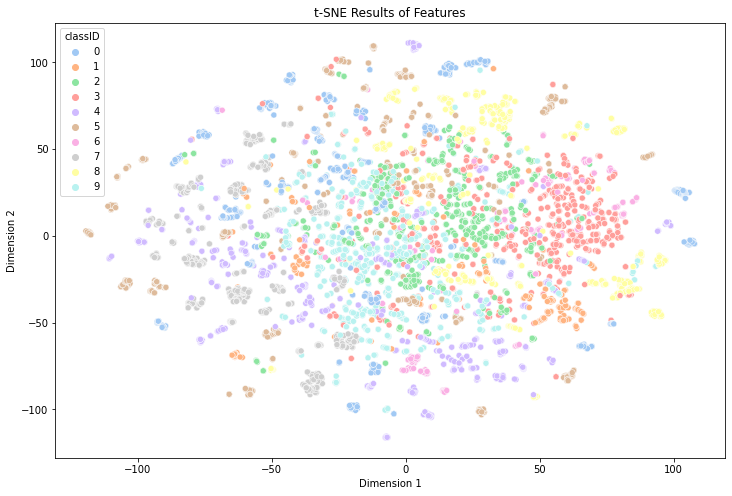

In [39]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=train_f_embedded[:, 0],
                y=train_f_embedded[:, 1], 
                hue=train_y,
                palette='pastel')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_oversampled_feature_pipeline)

In [41]:
pipe2 = make_oversampled_feature_pipeline()
pipe2.set_params(
**{'estimator': XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 98},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14a1865e0>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x147bd8790>,
                                     kw_args={'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 98, 'n_m...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [58]:
#return both x, y 
ov_train, ov_y = pipe2[:-3].fit_resample(train_fold, train_y)

In [59]:
new_x = pipe2[2:-1].fit_transform(ov_train)

### Visual -Features

In [60]:
ov_train_embedded = TSNE(n_components=2, learning_rate='auto', 
                        init='random', perplexity=12).fit_transform(new_x)

In [61]:
ov_train_embedded

array([[ 57.274994, -26.593555],
       [ 41.298943, -21.34024 ],
       [ 54.64664 , -51.20001 ],
       ...,
       [ 67.3314  ,  70.70134 ],
       [ 46.82285 ,  47.056004],
       [ 83.97625 ,  43.171642]], dtype=float32)

Text(0, 0.5, 'Dimension 2')

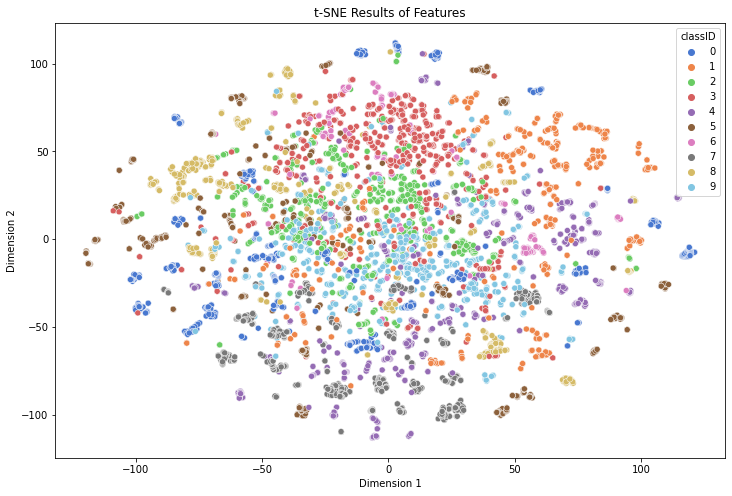

In [67]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=ov_train_embedded[:, 0],
                y=ov_train_embedded[:, 1], 
                hue=ov_y,
                palette='muted')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')